In [1]:
! pip install torchode torchdiffeq torchdyn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 718.6/718.6 kB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 19.0 MB/s eta 0:00:00


In [2]:
from typing import Callable, Tuple
import torch
import torchode
import torchdiffeq
import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange

# Task 1
Implement a step of the classical Runge-Kutta 4-th order method

In [3]:
def rk4_step(derivative: Callable[[torch.Tensor, torch.Tensor], torch.Tensor],
             x: torch.Tensor,
             t: torch.Tensor,
             t_step: torch.Tensor) -> torch.Tensor:
    """
    Makes one step of the classical Runge-Kutta 4-th order method.
    The function is agnostic towards x dimensions, the only requirement is that
    it matches the derivative function return shape.
    Args:
        derivative: dx/dt(t, x)
        x: value of the dependent variable x(t)
        t: scalar, value of independent variable, usually time
        t_step: scalar, integration step
    Returns:
        Estimated value of x(t + t_step)
    """
    k_1 = derivative(t, x)
    # Implement the remaining steps, see the course description
    # https://www.notion.so/Numerical-integration-of-ODE-c98b63a7bb8d47c8bde5282819710ed1#f2617691ebad45e0b25e0483a0f1c377
    ### YOUR CODE HERE
    return x + t_step * (k_1 + 2*k_2 + 2*k_3 + k_4) / 6

In [4]:
def odeint_rk4(derivative: Callable[[torch.Tensor, torch.Tensor], torch.Tensor],
               x_0: torch.Tensor,
               t_0: torch.Tensor,
               t_step: torch.Tensor,
               n_steps: int) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Uses rk4_step to integrate an ODE
    Args:
        derivative: dx/dt as a function of t and x
        x_0: initial condition
        t_0: initial independent variable value
        t_step: independent variable step
    Returns:
        x: tensor with x values
        t: tensor with independent variable values
    """
    t = torch.empty(n_steps, dtype=t_step.dtype, device=t_step.device)
    x = torch.empty([n_steps] + list(x_0.shape), dtype=x_0.dtype, device=x_0.device)
    t[0] = t_0.clone().detach()
    x[0] = x_0.clone().detach()
    for step in trange(n_steps - 1):
        x[step + 1] = rk4_step(derivative, x[step], t[step], t_step)   
        t[step + 1] = t[step] + t_step
    return x, t

# Test your implementation



  0%|          | 0/999 [00:00<?, ?it/s]

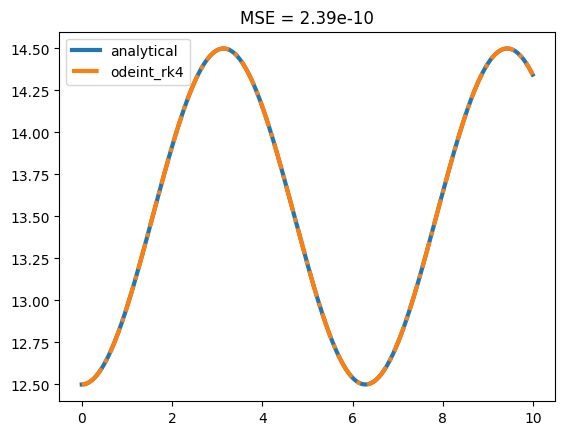

In [5]:
device = "cuda"

def sin_t(t, x):
    return torch.sin(t)

x_0 = torch.tensor(12.5).to(device)
t_0 = torch.tensor(0.).to(device)
t_step = torch.tensor(1e-2).to(device)
n_steps = 1000
with torch.no_grad():
    x_predicted, t = odeint_rk4(sin_t, x_0, t_0, t_step, n_steps)
    true_x = x_0 + 1 - torch.cos(t)
    mse = torch.nn.functional.mse_loss(x_predicted, true_x)

fig, ax = plt.subplots()
ax.plot(t.detach().cpu(), true_x.detach().cpu(), label="analytical", lw=3)
ax.plot(t.detach().cpu(), x_predicted.detach().cpu(), label="odeint_rk4", ls="-.", lw=3)
ax.set_title(f"MSE = {mse.detach().cpu():.3}")
ax.legend();

if mse.detach().cpu() > 1e-4:
    raise ValueError("odeint_rk4 answer is too far from the ground truth")

  0%|          | 0/999 [00:00<?, ?it/s]

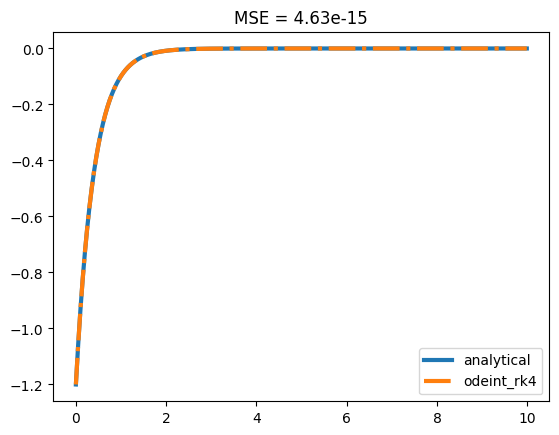

In [6]:
def linear_test(t, x):
    return -2.5 * x

x_0 = torch.tensor(-1.2).to(device)
t_0 = torch.tensor(0.).to(device)
t_step = torch.tensor(1e-2).to(device)
n_steps = 1000
with torch.no_grad():
    x_predicted, t = odeint_rk4(linear_test, x_0, t_0, t_step, n_steps)
    true_x = torch.exp(-2.5*t) * (-1.2)
    mse = torch.nn.functional.mse_loss(x_predicted, true_x)

fig, ax = plt.subplots()
ax.plot(t.detach().cpu(), true_x.detach().cpu(), label="analytical", lw=3)
ax.plot(t.detach().cpu(), x_predicted.detach().cpu(), label="odeint_rk4", ls="-.", lw=3)
ax.set_title(f"MSE = {mse.detach().cpu():.3}")
ax.legend()

if mse.detach().cpu() > 1e-4:
    raise ValueError("odeint_rk4 answer is too far from the ground truth")

  0%|          | 0/999 [00:00<?, ?it/s]

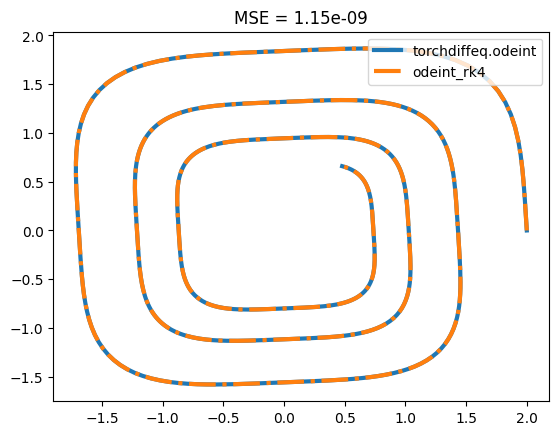

In [7]:
x_0 = torch.tensor([[2., 0.]]).to(device)
A = torch.tensor([[-0.1, 2.0], [-2.0, -0.1]]).to(device)

class Lambda(torch.nn.Module):
    def forward(self, t, x):
        return torch.mm(x**3, A)

with torch.no_grad():
    x_predicted, t = odeint_rk4(Lambda(), x_0, t_0, t_step, n_steps)
    true_x = torchdiffeq.odeint(Lambda(), x_0, t, method='dopri5')
    mse = torch.nn.functional.mse_loss(x_predicted, true_x)

fig, ax = plt.subplots()
ax.plot(true_x.detach().cpu()[:, 0, 0], true_x.detach().cpu()[:, 0, 1], label="torchdiffeq.odeint", lw=3);
ax.plot(x_predicted.detach().cpu()[:, 0, 0], x_predicted.detach().cpu()[:, 0, 1], label="odeint_rk4", ls="-.", lw=3);
ax.legend()
ax.set_title(f"MSE = {mse.detach().cpu():.3}")

if mse.detach().cpu() > 1e-4:
    raise ValueError("odeint_rk4 answer is too far from the reference")

# Task 2
Cause Sytem/GPU RAM overflow by attempting to backprop through a long enough ODE trajectory computed with our odeint_rk4. Comment the code, but attach a screenshot of the crash message.

In [8]:
### YOUR CODE HERE

# Task 3
Use the adjoint method to compute the derivative of the 0-th component of the final point of the trajectory with the respect to the initial conditions for your solution of Task 0.

Efficiently implementing adjoint integration is somewhat tricky, you are free to use a library. As of February 2023, there are three primary libraries: [torchdiffeq](https://github.com/rtqichen/torchdiffeq/), [TorchDyn](https://github.com/DiffEqML/torchdyn), and [torchode](https://github.com/martenlienen/torchode). We suggest torchode, as it is the fastest, thanks to JIT and other improvements.

In [9]:
### YOUR CODE HERE

(tensor([ 1.7018e-04,  1.6869e-04,  1.6867e-04,  ..., -4.4587e-10,
         -4.3919e-10, -4.2979e-10], device='cuda:0'),)